In [53]:
# basic modules
import numpy as np
import matplotlib.pyplot as plt
import sys

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision import models as torch_models
from torchvision import __version__ as torchvision_version

%load_ext autoreload
%autoreload 2

print("Torch version:", torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Torch version: 1.13.0a0+d0d6b1f


In [54]:
# include plots in notebook
%matplotlib inline

In [55]:
# check environment
print("Python version: ", sys.version)
print("Pytorch version: ", torch.__version__)
print("Torchvision version: ", torchvision_version)

!nvidia-smi

Python version:  3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
Pytorch version:  1.13.0a0+d0d6b1f
Torchvision version:  0.14.0a0
Thu Feb  2 20:02:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:34:00.0 Off |                    0 |
| N/A   37C    P0    69W / 350W |  32200MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+--

## prepare dataset

In [56]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *
from utils.mnist_general import *

# dataset parameters
DATASET_BATCH_SIZE = 128
DATASET_SHUFFLE = True
DATASET_TEST_FOOL_RANDOM_COLORS = True

# fileconfig
DATA_DIR='/home/patrick.koller/masterthesis/mnt_data/data'
MODEL_BACKUP_FILENAME = "standalone_resnet50_biased"

In [57]:
import clip

model, preprocess = clip.load("RN50")

MNIST dataset already exists


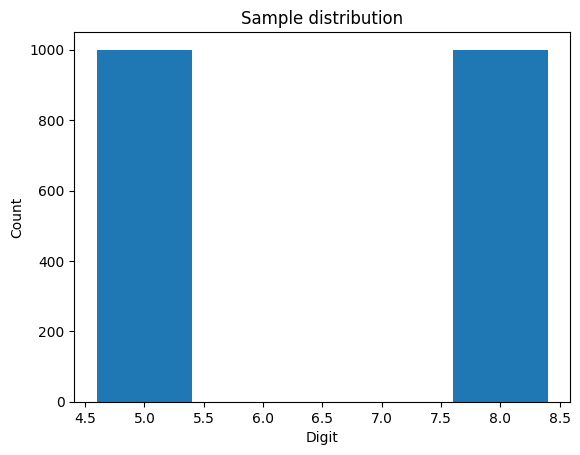

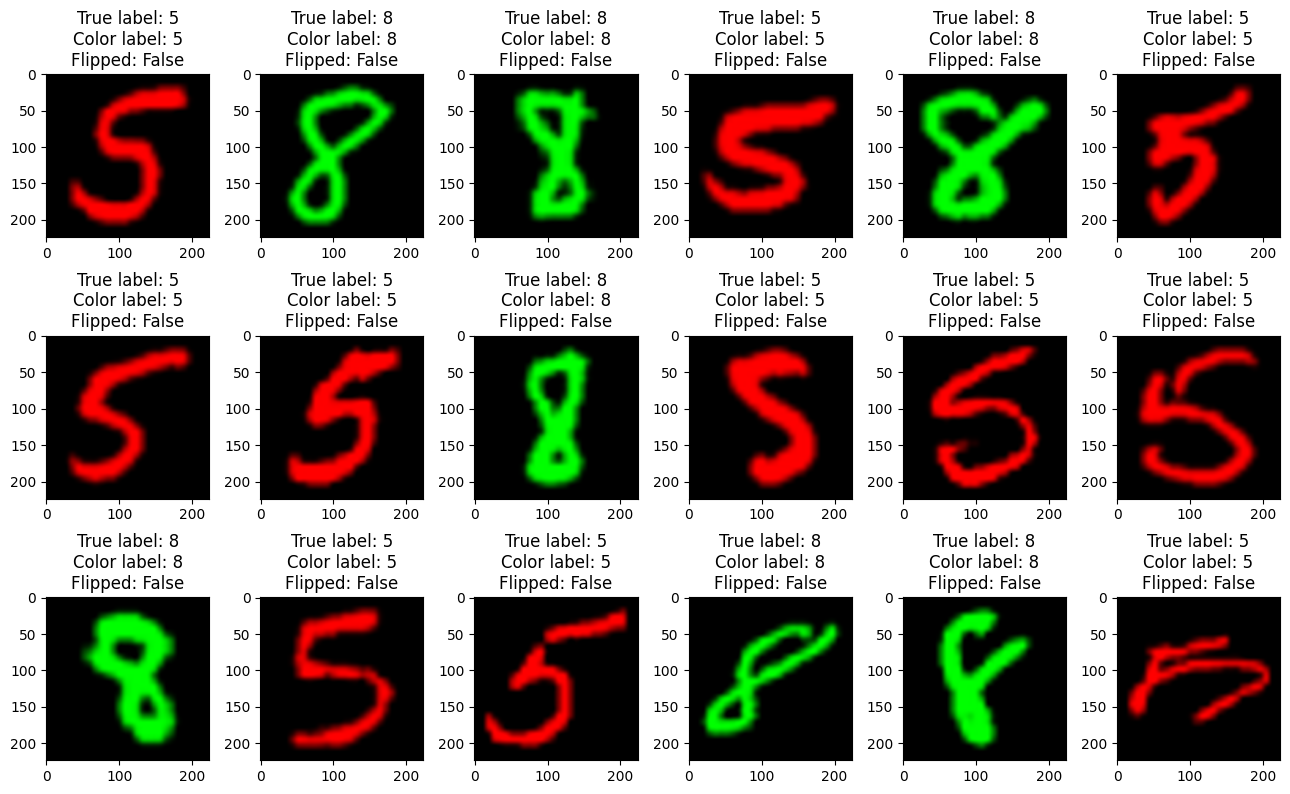

In [58]:
# create and select training dataset
# original 10 class problem
# DatasetMNIST(root='./data',
#                             env='train',
#                             color=True,
#                             opt_postfix="10classes",
#                             first_color_max_nr=4,
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
# DatasetMNIST(root='./data',
#                             env='train',
#                             color=False,
#                             opt_postfix="10classes",
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
data_set = DatasetMNIST(root=DATA_DIR,
                            env='test',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            test_fool_random=DATASET_TEST_FOOL_RANDOM_COLORS,
                            transform= transforms.Compose([transforms.ToTensor()]))

data_loader = torch.utils.data.DataLoader(dataset=data_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

digit_distribution(data_set)
plot_digits(data_set, preprocess)

## Setup GPU (For number crunching)

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## load models

In [60]:
import pickle

# load standalone model
standalone_model_biased = pickle.load(open(f"/home/patrick.koller/masterthesis/mnt_data/results/standalone_biased/standalone_resnet50_biased.mdl", 'rb'))
standalone_model_unbiased = pickle.load(open(f"/home/patrick.koller/masterthesis/mnt_data/results/standalone_unbiased/standalone_resnet50_unbiased.mdl", 'rb'))
standalone_model_biased.cuda()
standalone_model_unbiased.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [61]:
import clip

_, preprocess = clip.load("RN50")

# compute grad-cam

In [62]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()
    

In [63]:
# load data
img, ground_truth_label, low_high_label, color_label = next(iter(data_loader))
img = img[0].unsqueeze(dim=0).to(device)


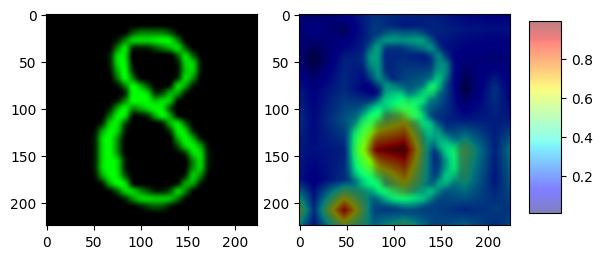

In [64]:
import skimage

# hook model
final_layer = standalone_model_biased._modules.get('layer4')
activated_features = SaveFeatures(final_layer)

# inference
preds = standalone_model_biased(img)

class_idx = torch.topk(preds,1)[1].int()
weight_softmax_params = list(standalone_model_biased._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

# grad-cam
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

overlay = getCAM(activated_features.features,
                 weight_softmax,
                 class_idx.cpu())

#plots
plt_img = clip_preprocess_inverse(img.cpu(), preprocess)

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(plt_img)
# plt.show()

# plt.imshow(overlay[0], alpha=0.5, cmap='jet')
# plt.show()

# plt.imshow(skimage.transform.resize(overlay[0], plt_img.shape[:2]), alpha=0.5, cmap='jet')
# plt.show()

axes[1].imshow(plt_img)
im2 = axes[1].imshow(skimage.transform.resize(overlay[0], plt_img.shape[:2]), alpha=0.5, cmap='jet')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.3, 0.05, 0.4])
fig.colorbar(im2, cax=cbar_ax)

plt.show()

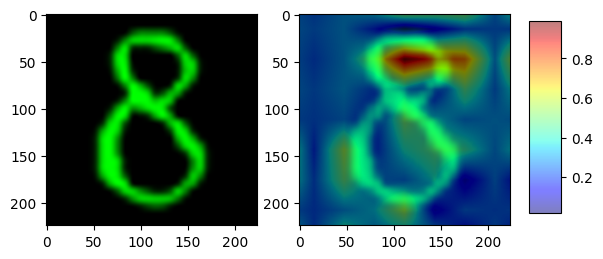

In [65]:
import skimage

# hook model
final_layer = standalone_model_unbiased._modules.get('layer4')
activated_features = SaveFeatures(final_layer)

# inference
preds = standalone_model_unbiased(img)

class_idx = torch.topk(preds,1)[1].int()
weight_softmax_params = list(standalone_model_unbiased._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

# grad-cam
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

overlay = getCAM(activated_features.features,
                 weight_softmax,
                 class_idx.cpu())

#plots
plt_img = clip_preprocess_inverse(img.cpu(), preprocess)

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(plt_img)
# plt.show()

# plt.imshow(overlay[0], alpha=0.5, cmap='jet')
# plt.show()

# plt.imshow(skimage.transform.resize(overlay[0], plt_img.shape[:2]), alpha=0.5, cmap='jet')
# plt.show()

axes[1].imshow(plt_img)
im2 = axes[1].imshow(skimage.transform.resize(overlay[0], plt_img.shape[:2]), alpha=0.5, cmap='jet')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.3, 0.05, 0.4])
fig.colorbar(im2, cax=cbar_ax)

plt.show()